In [93]:
%pip install mysql-connector-python sqlalchemy yfinance pandas


Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
import mysql.connector
import pandas as pd
import yfinance as yf
from sqlalchemy import create_engine

In [95]:
db_user = "root"
db_password = "welcome2u"
db_host = "localhost"  # Change if using a remote server
db_name = "stock_market"

In [96]:
engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}",echo = True)

In [97]:
#fetching stock data
ticker = "AAPL"

In [98]:
#Prices of last closing date -  Ticker object
stock = yf.Ticker(ticker)
price = stock.history(period="1d")
print(f"Real-time price for {ticker}: {price}")

Real-time price for AAPL:                                  Open        High         Low  Close  \
Date                                                                   
2025-03-17 00:00:00-04:00  213.309998  215.220001  209.970001  214.0   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-03-17 00:00:00-04:00  48042800        0.0           0.0  


In [99]:
df = yf.download(ticker, start="2021-01-01", end="2025-01-01", interval="1d")
df.reset_index(inplace=True)
df.info()


*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1005 non-null   datetime64[ns]
 1   (Close, AAPL)   1005 non-null   float64       
 2   (High, AAPL)    1005 non-null   float64       
 3   (Low, AAPL)     1005 non-null   float64       
 4   (Open, AAPL)    1005 non-null   float64       
 5   (Volume, AAPL)  1005 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 47.2 KB


In [100]:
df.columns = ['market_date', 'close_price',
             'high_price', 'low_price',
             'open_price', 'volume']

In [101]:
df.head()

,market_date,close_price,high_price,low_price,open_price,volume
0,2021-01-04,126.405212,130.507689,123.816742,130.419782,143301900
1,2021-01-05,127.968079,128.681140,125.447982,125.897308,97664900
2,2021-01-06,123.660492,128.007173,123.445599,124.754490,155088000
3,2021-01-07,127.880165,128.573686,124.891218,125.379608,109578200
4,2021-01-08,128.983917,129.550452,127.206169,129.355084,105158200


In [102]:
# Save DataFrame to MySQL table
df.to_sql("stock_prices", engine, if_exists="replace", index=True)

2025-03-18 12:47:23,428 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2025-03-18 12:47:23,478 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:23,525 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2025-03-18 12:47:23,525 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:23,540 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2025-03-18 12:47:23,540 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:23,556 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-18 12:47:23,618 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`stock_prices`
2025-03-18 12:47:23,618 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:23,962 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`stock_prices`
2025-03-18 12:47:23,962 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:23,962 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `stock_market`
2025-03-18 12:47:23,962 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:24,

1005

In [103]:
query = """
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg
FROM stock_prices
"""

In [104]:
df = pd.read_sql(query, engine)

2025-03-18 12:47:29,416 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-18 12:47:29,418 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg
FROM stock_prices
`
2025-03-18 12:47:29,418 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:29,422 INFO sqlalchemy.engine.Engine 
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg
FROM stock_prices

2025-03-18 12:47:29,423 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:29,664 INFO sqlalchemy.engine.Engine ROLLBACK


In [105]:
# Convert 'date' to datetime
df['market_date'] = pd.to_datetime(df['market_date'])

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

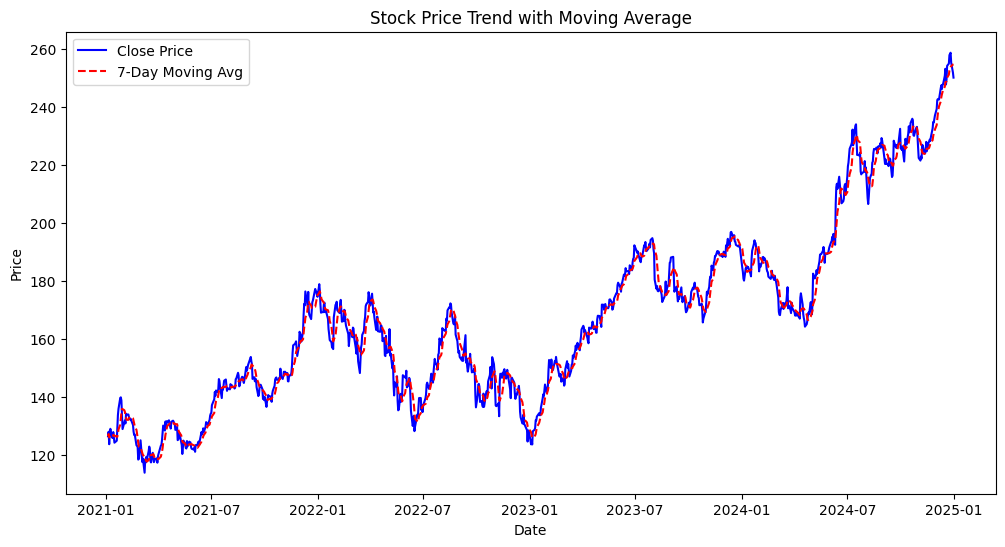

In [107]:
# Plot stock price trend with moving average
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['market_date'], y=df['close_price'], label="Close Price", color="blue")
sns.lineplot(x=df['market_date'], y=df['moving_avg'], label="7-Day Moving Avg", linestyle="dashed", color="red")
plt.title("Stock Price Trend with Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [108]:
import plotly.express as px

In [109]:
fig = px.line(df, x="market_date", y="close_price", title="Interactive Stock Price Chart",
              labels={"close_price": "Close Price ($)", "market_date": "Date"}, template="plotly_dark")

fig.show()

In [110]:
#PERCENTAGE CHANE IN STOCK PRICE
query = """
SELECT market_date, close_price,
       LAG(close_price) OVER (ORDER BY market_date) AS prev_close,
       (close_price - LAG(close_price) OVER (ORDER BY market_date)) / LAG(close_price) OVER (ORDER BY market_date) * 100 AS daily_return
FROM stock_prices
"""

In [111]:
df = pd.read_sql(query, engine)

2025-03-18 12:47:35,663 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-18 12:47:35,664 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`
SELECT market_date, close_price,
       LAG(close_price) OVER (ORDER BY market_date) AS prev_close,
       (close_price - LAG(close_price) OVER (ORDER BY market_date)) / LAG(close_price) OVER (ORDER BY market_date) * 100 AS daily_return
FROM stock_prices
`
2025-03-18 12:47:35,665 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:35,666 INFO sqlalchemy.engine.Engine 
SELECT market_date, close_price,
       LAG(close_price) OVER (ORDER BY market_date) AS prev_close,
       (close_price - LAG(close_price) OVER (ORDER BY market_date)) / LAG(close_price) OVER (ORDER BY market_date) * 100 AS daily_return
FROM stock_prices

2025-03-18 12:47:35,667 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:35,890 INFO sqlalchemy.engine.Engine ROLLBACK


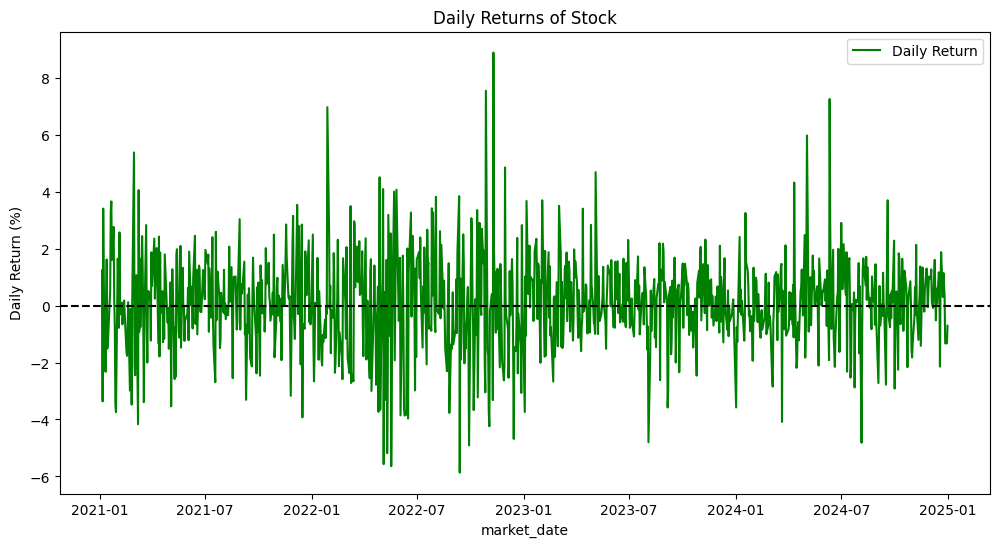

In [112]:
# Plot Daily Returns
#Identifying high volatile periods
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['market_date'], y=df['daily_return'], label="Daily Return", color="green")
plt.axhline(y=0, linestyle="dashed", color="black")  # Baseline
plt.title("Daily Returns of Stock")
plt.ylabel("Daily Return (%)")
plt.show()

In [113]:
query ="""
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 49 PRECEDING AND CURRENT ROW) AS ma_50,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 199 PRECEDING AND CURRENT ROW) AS ma_200
FROM stock_prices
"""
df = pd.read_sql(query, engine)

2025-03-18 12:47:36,691 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-18 12:47:36,691 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 49 PRECEDING AND CURRENT ROW) AS ma_50,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 199 PRECEDING AND CURRENT ROW) AS ma_200
FROM stock_prices
`
2025-03-18 12:47:36,691 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:36,691 INFO sqlalchemy.engine.Engine 
SELECT market_date, close_price,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 49 PRECEDING AND CURRENT ROW) AS ma_50,
       AVG(close_price) OVER (ORDER BY market_date ROWS BETWEEN 199 PRECEDING AND CURRENT ROW) AS ma_200
FROM stock_prices

2025-03-18 12:47:36,691 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:36,754 INFO sqlalchemy.engine.Engine ROLLBACK


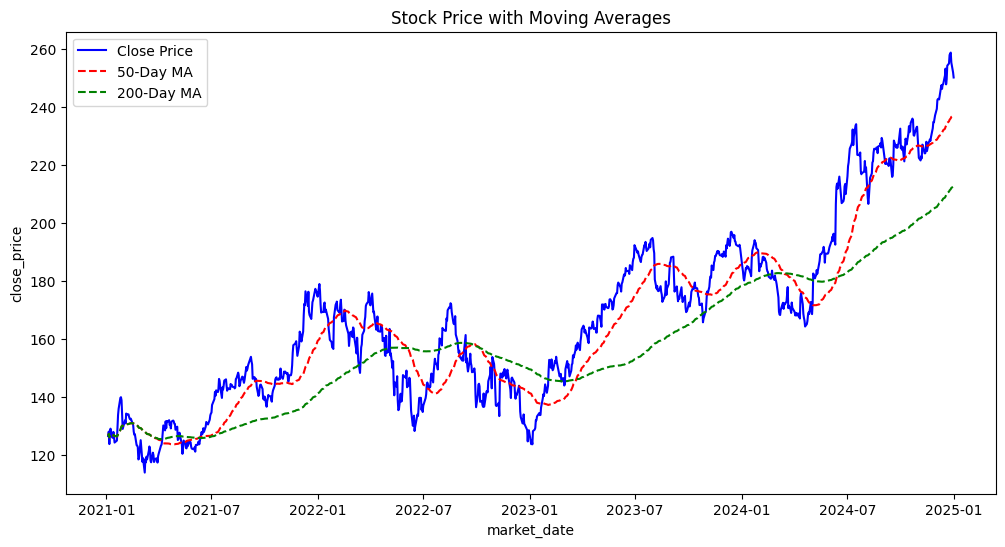

In [114]:
# Plot Moving Averages
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['market_date'], y=df['close_price'], label="Close Price", color="blue")
sns.lineplot(x=df['market_date'], y=df['ma_50'], label="50-Day MA", linestyle="dashed", color="red")
sns.lineplot(x=df['market_date'], y=df['ma_200'], label="200-Day MA", linestyle="dashed", color="green")
plt.title("Stock Price with Moving Averages")
plt.legend()
plt.show()

In [115]:
query = """
SELECT market_date, close_price,
       close_price - LAG(close_price) OVER (ORDER BY market_date) AS price_change,
       CASE 
           WHEN close_price - LAG(close_price) OVER (ORDER BY market_date) > 0 THEN close_price - LAG(close_price) OVER (ORDER BY market_date)
           ELSE 0
       END AS gain,
       CASE 
           WHEN close_price - LAG(close_price) OVER (ORDER BY market_date) < 0 THEN ABS(close_price - LAG(close_price) OVER (ORDER BY market_date))
           ELSE 0
       END AS loss
FROM stock_prices;
"""

In [116]:
df = pd.read_sql(query, engine)

2025-03-18 12:47:37,720 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-18 12:47:37,720 INFO sqlalchemy.engine.Engine DESCRIBE `stock_market`.`
SELECT market_date, close_price,
       close_price - LAG(close_price) OVER (ORDER BY market_date) AS price_change,
       CASE 
           WHEN close_price - LAG(close_price) OVER (ORDER BY market_date) > 0 THEN close_price - LAG(close_price) OVER (ORDER BY market_date)
           ELSE 0
       END AS gain,
       CASE 
           WHEN close_price - LAG(close_price) OVER (ORDER BY market_date) < 0 THEN ABS(close_price - LAG(close_price) OVER (ORDER BY market_date))
           ELSE 0
       END AS loss
FROM stock_prices;
`
2025-03-18 12:47:37,720 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-18 12:47:37,720 INFO sqlalchemy.engine.Engine 
SELECT market_date, close_price,
       close_price - LAG(close_price) OVER (ORDER BY market_date) AS price_change,
       CASE 
           WHEN close_price - LAG(close_price) OVER (ORDER BY market_

In [117]:
# Compute RSI
df['avg_gain'] = df['gain'].rolling(window=14).mean()
df['avg_loss'] = df['loss'].rolling(window=14).mean()
df['rs'] = df['avg_gain'] / df['avg_loss']
df['rsi'] = 100 - (100 / (1 + df['rs']))

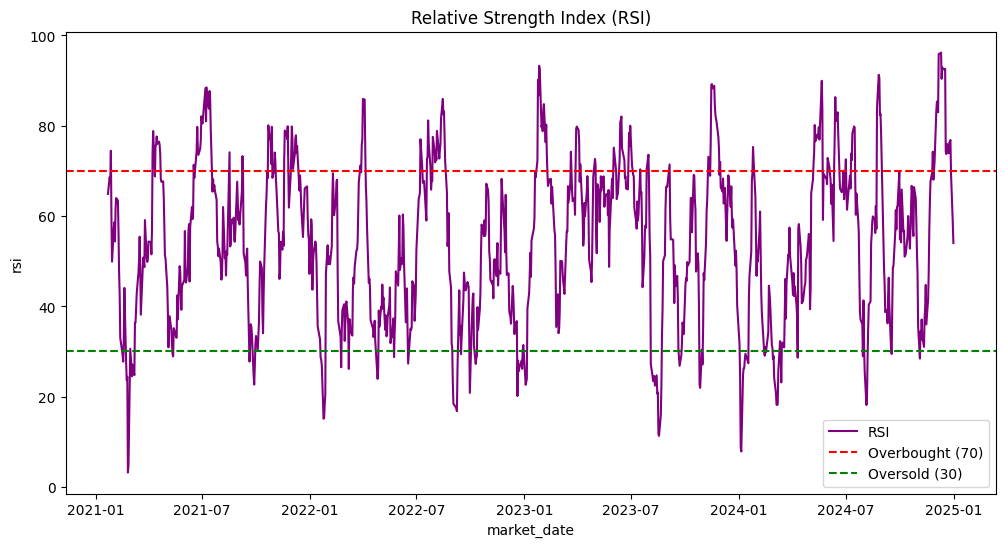

In [118]:
# Plot RSI
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['market_date'], y=df['rsi'], label="RSI", color="purple")
plt.axhline(70, linestyle="dashed", color="red", label="Overbought (70)")
plt.axhline(30, linestyle="dashed", color="green", label="Oversold (30)")
plt.title("Relative Strength Index (RSI)")
plt.legend()
plt.show()


*********************100%***********************]  4 of 4 completed

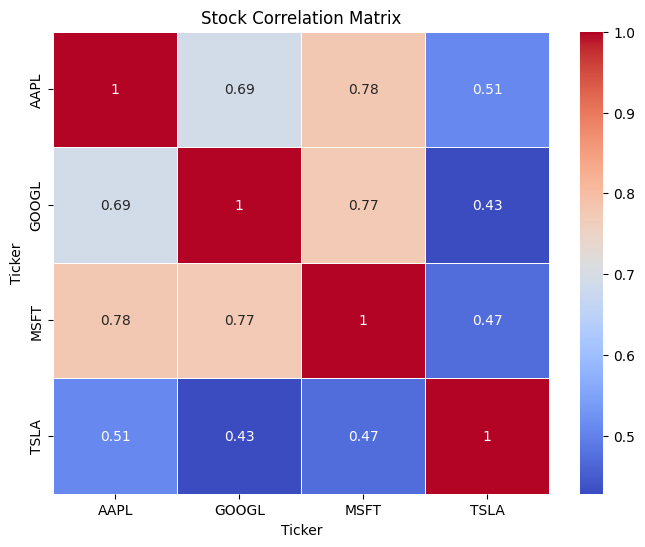

In [119]:
#Correlation Between Stocks
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]
df2 = yf.download(tickers, start="2020-01-01", end="2024-01-01")["Close"]

# Compute correlation matrix
corr_matrix = df2.pct_change().corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Stock Correlation Matrix")
plt.show()